In [36]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# TODO look back at the Spotify classification code to get an idea of how best to do this?

In [3]:
df = pd.read_feather('clean_data.feather')

In [5]:
df.head()

,LCLid,stdorToU,DateTime,KWH/hh,Acorn,Acorn_grouped,Time
0,MAC000756,Std,2014-02-12 17:00:00,0.077,ACORN-E,Affluent,17:00:00
1,MAC000756,Std,2014-02-12 17:30:00,0.082,ACORN-E,Affluent,17:30:00
2,MAC000756,Std,2014-02-12 18:00:00,0.121,ACORN-E,Affluent,18:00:00
3,MAC000756,Std,2014-02-12 18:30:00,0.144,ACORN-E,Affluent,18:30:00
4,MAC000756,Std,2014-02-12 19:00:00,0.177,ACORN-E,Affluent,19:00:00


In [49]:
df.rename(columns={'Acorn_grouped_ACORN-' : 'Acorn_grouped_ACORN'}, inplace=True) # rename these col so I can drop them.
df.rename(columns={'Acorn_grouped_ACORN-U' : 'Acorn_grouped_ACORNU'}, inplace=True) # rename these col so I can drop them.
df = df.drop(df[(df.Acorn_grouped == "ACORN-U") | (df.Acorn_grouped == "ACORN-")].index)

In [ ]:
# Classification??

# Start with clustering I suppose? 


## Steps
1. Group by household ID and get a daily average and group by that first see what our accuarcy is.
1. Maybe look at the variance by half hour to use in some manner.
1. Take averages of the Groups and try to do SVG style clustering?
1. Density based clustering?

## Ideas
1. Grouping by household and using their mean, max and min might be easiest to work with.
1. Secondardily we can look at times of day. Maybe break the day up into General periods. Home-Awake, Home-Sleep, Away?
    1. This could help us see who is working which could show income levels?

In [50]:
group_df = df.groupby("LCLid").agg({"KWH/hh": ["mean", "min", "max"], "Acorn_grouped": "first"}) # Might want the 25% and 75%

In [51]:
base_df = group_df.droplevel(0, axis=1).reset_index()[["mean", "max"]]

In [52]:
base_df.head()

,mean,max
0,0.252551,2.994
1,0.397655,3.921
2,0.035382,1.065
3,0.095385,1.979
4,0.059470,0.801


In [53]:
# Probably need to split into train, test, validation sets.

In [54]:
kmeans = KMeans(n_clusters = 3, random_state = 5).fit(base_df)

In [55]:
kmeans.labels_

array([0, 1, 2, ..., 2, 1, 2], dtype=int32)

In [56]:
group_df["Cluster"] = kmeans.labels_

In [57]:
group_df

KWH/hh             Acorn_grouped Cluster
               mean  min    max         first        
LCLid                                                
MAC000002  0.252551  0.0  2.994      Affluent       0
MAC000003  0.397655  0.0  3.921     Adversity       1
MAC000004  0.035382  0.0  1.065      Affluent       2
MAC000005  0.095385  0.0  1.979      Affluent       2
MAC000006  0.059470  0.0  0.801     Adversity       2
...             ...  ...    ...           ...     ...
MAC005563  0.000000  0.0  0.000     Adversity       2
MAC005564  0.083901  0.0  3.232     Adversity       0
MAC005565  0.128667  0.0  1.022      Affluent       2
MAC005566  0.363085  0.0  3.936      Affluent       1
MAC005567  0.108556  0.0  1.528     Adversity       2

[5515 rows x 5 columns]

In [58]:
group_df.droplevel(1, axis=1).groupby(["Acorn_grouped", "Cluster"]).count()

KWH/hh  KWH/hh  KWH/hh
Acorn_grouped Cluster                        
Adversity     0           610     610     610
              1           152     152     152
              2          1054    1054    1054
Affluent      0           886     886     886
              1           363     363     363
              2           943     943     943
Comfortable   0           615     615     615
              1           170     170     170
              2           722     722     722

In [59]:
group_df.columns = group_df.columns.map('_'.join)

In [60]:
group_df

,KWH/hh_mean,KWH/hh_min,KWH/hh_max,Acorn_grouped_first,Cluster_
LCLid,,,,,
MAC000002,0.252551,0.0,2.994,Affluent,0
MAC000003,0.397655,0.0,3.921,Adversity,1
MAC000004,0.035382,0.0,1.065,Affluent,2
MAC000005,0.095385,0.0,1.979,Affluent,2
MAC000006,0.059470,0.0,0.801,Adversity,2
...,...,...,...,...,...
MAC005563,0.000000,0.0,0.000,Adversity,2
MAC005564,0.083901,0.0,3.232,Adversity,0
MAC005565,0.128667,0.0,1.022,Affluent,2


In [61]:
group_df["Acorn_grouped_first"].unique()

array(['Affluent', 'Adversity', 'Comfortable'], dtype=object)

In [62]:
colors = ['#DF2020', '#81DF20', '#2095DF']
group_df['c'] = group_df.Cluster_.map({0:colors[0], 1:colors[1], 2:colors[2]})
group_df['d'] = group_df["Acorn_grouped_first"].map({"Affluent":colors[0], "Comfortable":colors[1], "Adversity":colors[2]})

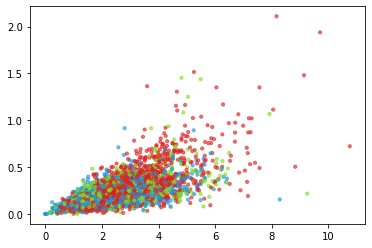

In [63]:
plt.scatter(group_df["KWH/hh_max"], group_df["KWH/hh_mean"], c=group_df.d, alpha = 0.6, s=10)

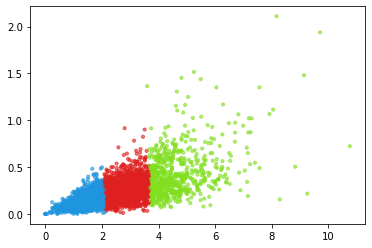

In [64]:
plt.scatter(group_df["KWH/hh_max"], group_df["KWH/hh_mean"], c=group_df.c, alpha = 0.6, s=10)

In [76]:
base_df["mean"].to_numpy().reshape(-1,1)

array([[0.25255145],
       [0.39765522],
       [0.03538176],
       ...,
       [0.12866667],
       [0.36308547],
       [0.10855553]])

In [75]:
kmeans2 = KMeans(n_clusters = 3, random_state = 5).fit(base_df["mean"].to_numpy().reshape(-1,1))

In [77]:
group_df["Cluster_2"] = kmeans2.labels_

In [78]:
group_df.head()

,KWH/hh_mean,KWH/hh_min,KWH/hh_max,Acorn_grouped_first,Cluster_,c,d,Cluster_2
LCLid,,,,,,,,
MAC000002,0.252551,0.0,2.994,Affluent,0,#DF2020,#DF2020,2
MAC000003,0.397655,0.0,3.921,Adversity,1,#81DF20,#2095DF,2
MAC000004,0.035382,0.0,1.065,Affluent,2,#2095DF,#DF2020,1
MAC000005,0.095385,0.0,1.979,Affluent,2,#2095DF,#DF2020,1
MAC000006,0.059470,0.0,0.801,Adversity,2,#2095DF,#2095DF,1


In [81]:
group_df.groupby(["Acorn_grouped_first", "Cluster_2"]).count()

KWH/hh_mean  KWH/hh_min  KWH/hh_max  Cluster_  \
Acorn_grouped_first Cluster_2                                                  
Adversity           0                   24          24          24        24   
                    1                 1320        1320        1320      1320   
                    2                  472         472         472       472   
Affluent            0                  166         166         166       166   
                    1                 1275        1275        1275      1275   
                    2                  751         751         751       751   
Comfortable         0                   39          39          39        39   
                    1                  925         925         925       925   
                    2                  543         543         543       543   

                                  c     d  
Acorn_grouped_first Cluster_2              
Adversity           0            24    24  
                    1          1320  1320  
                    2           472   472  
Affluent            0           166   166  
                    1          1275  1275  
                    2           751   751  
Comfortable         0            39    39  
                    1           925   925  
                    2           543   543

In [82]:
group_df['c2'] = group_df.Cluster_2.map({0:colors[0], 1:colors[1], 2:colors[2]})

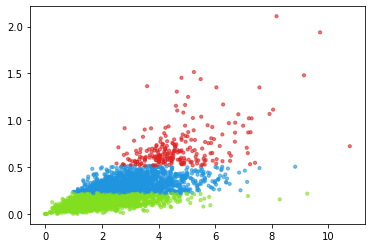

In [83]:
plt.scatter(group_df["KWH/hh_max"], group_df["KWH/hh_mean"], c=group_df.c2, alpha = 0.6, s=10)

## Thoughts at this point. End of Update 1

1. First off this was always going to be hard because income level does not determine what you do for fun in your free time. Some people have a lot of money and watch a lot of TV. Some people have no money or Job so they watch a lot of TV. 
1. I think there are quite a few outliers so I think maybe we do something to separate those out of the dataset and try again.
1. Split Into averages for time of day I think this might get us closer to what we are looking for. 
1. Make sure each cluster has close to the same number of values? 
    1. So far there has always been 1 with far few values than the others. 
    1. I think that this coinsides with the outliers forcing a centroid to far away from the rest of the data.



In [ ]:
# 0-8 Sleep, 8-16 Away, 16-24 Home? Just as a general breakdown of average people's days?
